In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold


path = '/home/dell/Documentos/rn-cin-covid/'
os.chdir(path)


In [2]:
def evaluate_knn(model, X_test, y_test):
    
    y_pred = model.predict(X_test)
    
    print("Acurácia teste: ", accuracy_score(y_test, y_pred))
    print("   ")
    
    print(classification_report(y_test, y_pred))
    
    df_cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize = (10,7))
    sn.heatmap(df_cm, annot=True, fmt='.3g')
    plt.show()

In [3]:
def train_predict_KNN(df_total, test):
    # Train
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()
    
    #Test
    y_test = test[0]
    X_test = test.drop(0, axis=1)

    y_test = y_test.to_numpy()
    X_test = X_test.to_numpy()
    
    # Grid
    k_range = list(range(1,30))
    weight_options = ["uniform", "distance"]

    param_grid = dict(n_neighbors = k_range, weights = weight_options)
    #print (param_grid)
    knn = KNeighborsClassifier()
    folds = 10
    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    
    grid = GridSearchCV(knn, param_grid, cv = skf, scoring = 'accuracy')
    grid.fit(X,y)

    #print(grid.grid_scores_)
    '''
    print(grid.grid_scores_[0].parameters)
    print(grid.grid_scores_[0].cv_validation_scores)
    print(grid.grid_scores_[0].mean_validation_score)
    '''

    print ("Best Score: ", grid.best_score_)
    print ("Best params: ", grid.best_params_)
    print("\n")
    
    evaluate_knn(grid.best_estimator_, X_test, y_test)
    return grid.best_params_ 

In [4]:
def treina_melhor_modelo(df_total,test,best_params,base_name):
    y = df_total[0]
    X = df_total.drop(0, axis=1)

    y = y.to_numpy()
    X = X.to_numpy()

    test_true_x = test.drop(0, axis=1).to_numpy()
    test_true_y = test[0].to_numpy()

    knn = KNeighborsClassifier(best_params['n_neighbors'], best_params['weights'])
    knn_results = pd.DataFrame(columns=["base", "acuracia-teste", "precision-covid-teste", "recall-covid-teste", "f1-covid-teste", "precision-non-covid-teste", "recall-non-covid-teste", "f1-non-covid-teste", "conf-matrix-teste", "acuracia-val", "precision-covid-val", "recall-covid-val", "f1-covid-val", "precision-non-covid-val", "recall-non-covid-val", "f1-non-covid-val", "conf-matrix-val"])

    folds = 30

    skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 999)
    StratifiedKFold(n_splits=2, random_state=None, shuffle=False)


    acuracia_test = []
    acuracia_val = []
    pre_covid_t = []
    re_covid_t = []
    f1_covid_t = []
    pre_ncovid_t = []
    re_ncovid_t = []
    f1_ncovid_t = []
    pre_covid_v = []
    re_covid_v = []
    f1_covid_v = []
    pre_ncovid_v = []
    re_ncovid_v = []
    f1_ncovid_v = []
    base = []
    conf_matrix_val = []
    conf_matrix_test = []





    for train_index, test_index in skf.split(X, y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        y_pred_true = knn.predict(test_true_x) 




        df_cm = confusion_matrix(y_test, y_pred)
        df_cm_test = confusion_matrix(test_true_y, y_pred_true)   
        class_repo = classification_report(y_test, y_pred, output_dict=True)
        class_repo_test = classification_report(test_true_y, y_pred_true, output_dict=True)

        base.append(base_name)
        acuracia_test.append(accuracy_score(test_true_y, y_pred_true))
        acuracia_val.append(accuracy_score(y_test, y_pred))

        pre_covid_t.append(class_repo_test['1']["precision"])
        re_covid_t.append(class_repo_test['1']["recall"])
        f1_covid_t.append(class_repo_test['1']["f1-score"])
        pre_ncovid_t.append(class_repo_test['0']["precision"])
        re_ncovid_t.append(class_repo_test['0']["recall"])
        f1_ncovid_t.append(class_repo_test['0']["f1-score"])

        pre_covid_v.append(class_repo['1']["precision"])
        re_covid_v.append(class_repo['1']["recall"])
        f1_covid_v.append(class_repo['1']["f1-score"])
        pre_ncovid_v.append(class_repo['0']["precision"])
        re_ncovid_v.append(class_repo['0']["recall"])
        f1_ncovid_v.append(class_repo['0']["f1-score"])

        conf_matrix_val.append(df_cm)
        conf_matrix_test.append(df_cm_test)


    knn_results["acuracia-teste"] = acuracia_test
    knn_results["acuracia-val"] = acuracia_val 
    knn_results["precision-covid-teste"] = pre_covid_t 
    knn_results["recall-covid-teste"] = re_covid_t 
    knn_results["f1-covid-teste"] = f1_covid_t 
    knn_results["precision-non-covid-teste"] = pre_ncovid_t
    knn_results["recall-non-covid-teste"] = re_ncovid_t 
    knn_results["f1-non-covid-teste"] = f1_ncovid_t 
    knn_results["precision-covid-val"] = pre_covid_v 
    knn_results["recall-covid-val"] = re_covid_v 
    knn_results["f1-covid-val"] = f1_covid_v 
    knn_results["precision-non-covid-val"] = pre_ncovid_v 
    knn_results["recall-non-covid-val"] = re_ncovid_v 
    knn_results["f1-non-covid-val"] = f1_ncovid_v 
    knn_results["base"] = base 
    knn_results["conf-matrix-val"] = conf_matrix_val
    knn_results["conf-matrix-teste"] = conf_matrix_test 
    
    return(knn_results)

### Densenet Normal


(5394, 1025)
Best Score:  0.9781199752628323
Best params:  {'n_neighbors': 5, 'weights': 'distance'}


Acurácia teste:  0.9028132992327366
   
              precision    recall  f1-score   support

           0       0.75      0.94      0.83       100
           1       0.98      0.89      0.93       291

    accuracy                           0.90       391
   macro avg       0.86      0.92      0.88       391
weighted avg       0.92      0.90      0.91       391



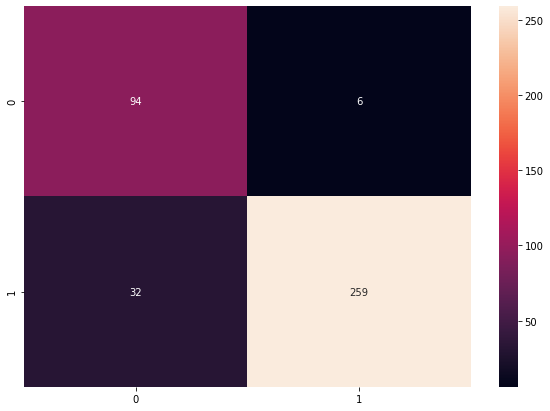

In [5]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)

In [6]:
test = pd.read_csv("output/output_densenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = treina_melhor_modelo(df_total, test, best_params, "densenet")

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### Densenet Augmentation


(10788, 1025)
Best Score:  0.9724692691129867
Best params:  {'n_neighbors': 4, 'weights': 'distance'}


Acurácia teste:  0.9258312020460358
   
              precision    recall  f1-score   support

           0       0.78      0.98      0.87       100
           1       0.99      0.91      0.95       291

    accuracy                           0.93       391
   macro avg       0.89      0.94      0.91       391
weighted avg       0.94      0.93      0.93       391



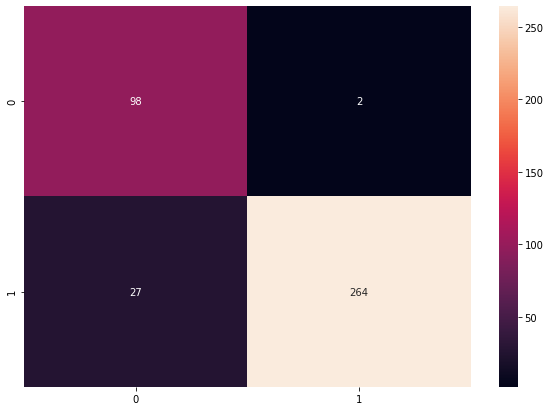

In [7]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)


In [8]:
test = pd.read_csv("output/output_densenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_densenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_densenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "densenet_gauss")])

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### MobileNet Normal

(5394, 1281)
Best Score:  0.9566158180443894
Best params:  {'n_neighbors': 4, 'weights': 'distance'}


Acurácia teste:  0.8542199488491049
   
              precision    recall  f1-score   support

           0       0.64      0.96      0.77       100
           1       0.98      0.82      0.89       291

    accuracy                           0.85       391
   macro avg       0.81      0.89      0.83       391
weighted avg       0.90      0.85      0.86       391



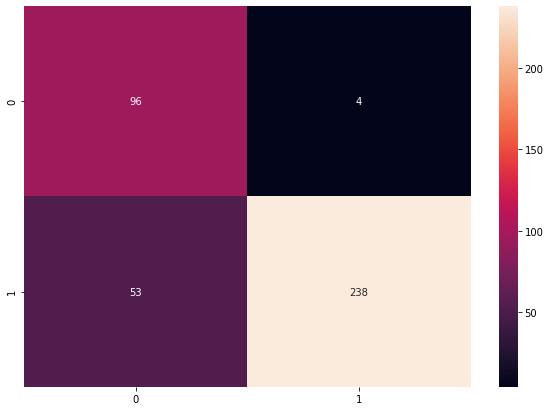

In [9]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)

In [10]:
test = pd.read_csv("output/output_mobilenet_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet")])

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### MobileNet Augmentation

(10788, 1281)
Best Score:  0.9372453708081936
Best params:  {'n_neighbors': 4, 'weights': 'distance'}


Acurácia teste:  0.8491048593350383
   
              precision    recall  f1-score   support

           0       0.64      0.95      0.76       100
           1       0.98      0.81      0.89       291

    accuracy                           0.85       391
   macro avg       0.81      0.88      0.83       391
weighted avg       0.89      0.85      0.86       391



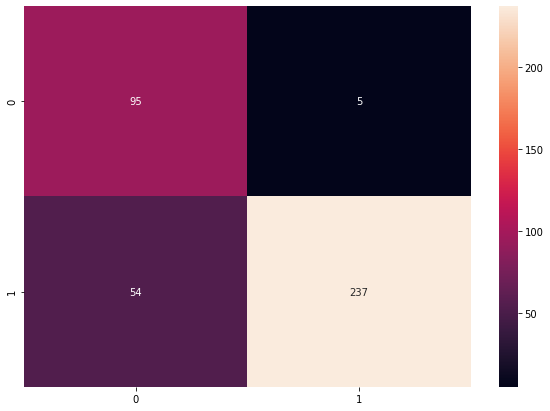

In [12]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)

In [13]:
test = pd.read_csv("output/output_mobilenet_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_mobilenet_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_mobilenet_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "mobilenet_gauss")])

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### VGG16 Normal

(5394, 513)
Best Score:  0.9773823266680409
Best params:  {'n_neighbors': 6, 'weights': 'distance'}


Acurácia teste:  0.907928388746803
   
              precision    recall  f1-score   support

           0       0.76      0.93      0.84       100
           1       0.97      0.90      0.94       291

    accuracy                           0.91       391
   macro avg       0.87      0.92      0.89       391
weighted avg       0.92      0.91      0.91       391



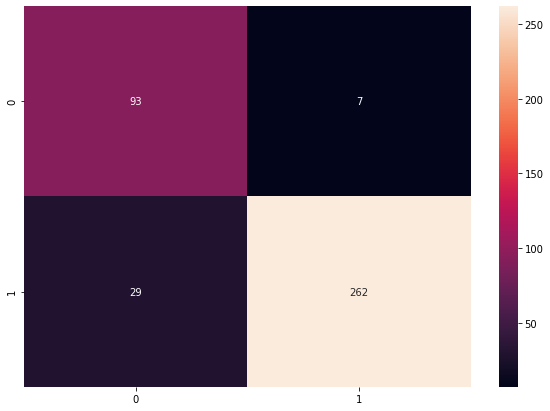

In [14]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)

In [15]:
test = pd.read_csv("output/output_vgg16_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16")])

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


### VGG16 Augmentation

(10788, 513)
Best Score:  0.9582864639663263
Best params:  {'n_neighbors': 4, 'weights': 'distance'}


Acurácia teste:  0.9053708439897699
   
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       100
           1       0.97      0.90      0.93       291

    accuracy                           0.91       391
   macro avg       0.87      0.91      0.88       391
weighted avg       0.92      0.91      0.91       391



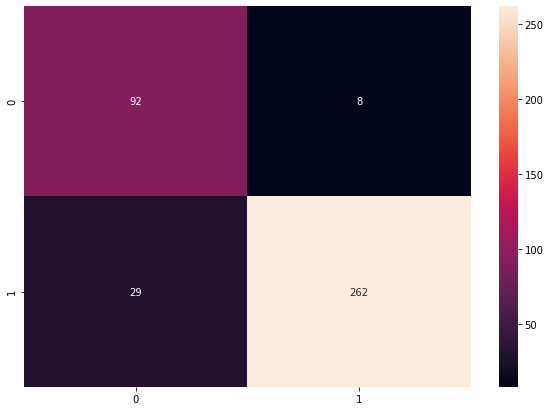

In [16]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])
print(df_total.shape)


best_params = train_predict_KNN(df_total, test)

In [18]:
test = pd.read_csv("output/output_vgg16_gauss_test_retrained.csv", header=None)
train = pd.read_csv("output/output_vgg16_gauss_train_retrained.csv", header=None)
val = pd.read_csv("output/output_vgg16_gauss_val_retrained.csv", header=None)

df_total = pd.concat([train,val])

results = pd.concat([results,treina_melhor_modelo(df_total, test, best_params, "vgg16_gauss")])

/home/dell/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass weights=distance as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [19]:
results

,base,acuracia-teste,precision-covid-teste,recall-covid-teste,f1-covid-teste,precision-non-covid-teste,recall-non-covid-teste,f1-non-covid-teste,conf-matrix-teste,acuracia-val,precision-covid-val,recall-covid-val,f1-covid-val,precision-non-covid-val,recall-non-covid-val,f1-non-covid-val,conf-matrix-val
0,densenet,0.902813,0.977358,0.890034,0.931655,0.746032,0.94,0.831858,"[[94, 6], [32, 259]]",0.972222,0.985507,0.944444,0.964539,0.963964,0.990741,0.977169,"[[107, 1], [4, 68]]"
1,densenet,0.905371,0.977444,0.893471,0.933573,0.752000,0.94,0.835556,"[[94, 6], [31, 260]]",0.983333,1.000000,0.958333,0.978723,0.972973,1.000000,0.986301,"[[108, 0], [3, 69]]"
2,densenet,0.902813,0.980989,0.886598,0.931408,0.742188,0.95,0.833333,"[[95, 5], [33, 258]]",0.988889,1.000000,0.972222,0.985915,0.981818,1.000000,0.990826,"[[108, 0], [2, 70]]"
3,densenet,0.905371,0.981061,0.890034,0.933333,0.748031,0.95,0.837004,"[[95, 5], [32, 259]]",0.983333,0.985915,0.972222,0.979021,0.981651,0.990741,0.986175,"[[107, 1], [2, 70]]"
4,densenet,0.902813,0.977358,0.890034,0.931655,0.746032,0.94,0.831858,"[[94, 6], [32, 259]]",0.983333,0.985915,0.972222,0.979021,0.981651,0.990741,0.986175,"[[107, 1], [2, 70]]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,vgg16_gauss,0.900256,0.970149,0.893471,0.930233,0.747967,0.92,0.825112,"[[92, 8], [31, 260]]",0.961003,0.945205,0.958333,0.951724,0.971831,0.962791,0.967290,"[[207, 8], [6, 138]]"
26,vgg16_gauss,0.907928,0.973978,0.900344,0.935714,0.762295,0.93,0.837838,"[[93, 7], [29, 262]]",0.969359,0.958333,0.965035,0.961672,0.976744,0.972222,0.974478,"[[210, 6], [5, 138]]"
27,vgg16_gauss,0.907928,0.970480,0.903780,0.935943,0.766667,0.92,0.836364,"[[92, 8], [28, 263]]",0.933148,0.916084,0.916084,0.916084,0.944444,0.944444,0.944444,"[[204, 12], [12, 131]]"
28,vgg16_gauss,0.902813,0.970260,0.896907,0.932143,0.754098,0.92,0.828829,"[[92, 8], [30, 261]]",0.958217,0.950704,0.944056,0.947368,0.963134,0.967593,0.965358,"[[209, 7], [8, 135]]"
